## Lab 8: Understanding  regression models
In this part, you will play with regularized linear regression (L1 and L2) and use it to study models with different bias-variance properties.
- first I show you how to explore L2 and L1 regularization with  with an artificial one-dimensional data set
- then you will work with the MLData diabetes dataset for this week's lab.
    - L1 and L2 linear regression models
    - KNN 
    - DecisionTreeRegressor 
    - RandomForestRegressor models

### Load up all the packages we need

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

from sklearn import datasets
from sklearn.datasets import load_diabetes

import warnings
warnings.filterwarnings("ignore")



# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Regularized Linear Regression cost function and gradient
Below is an implementation of the loss function and gradient of the
loss function for regularized linear regression on multiple predictors. 
Regularized linear regression has the following cost function:
$$J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^{m} {( y^{(i)} - h_\theta(x^{(i)})}^2\right) + \frac{\lambda}{2m}\left( \sum_{j=1}^{n} {\theta_j}^2 \right) $$
where $\lambda$ is a regularization parameter which controls the degree of regularization
(thus, help preventing overfitting). The regularization term puts
a penalty on the overall cost $J(\theta)$. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize the $\theta_0$ term.  Note the vectorized code.

Correspondingly, the partial derivative of the regularized linear regression  cost function
with respect to  $\theta_j$ is defined as:
\begin{eqnarray*}
\frac{\partial J(\theta)}{\partial \theta_0} & = & \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}){x_j}^{(i)} \\
\frac{\partial J(\theta)}{\partial \theta_j} & = & \left(\frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)} ){x_j}^{(i)}\right) + \frac{\lambda}{m}{\theta_j} \; \; \; \mbox{ for }j \geq 1\\
\end{eqnarray*}

### L2 Regularized Linear Regression: a simple example

In this problem, you will see the impact of regularization on model fitting.
The true model is $cos(1.5\pi x)$, and the data consists of x drawn from the interval [0,1] and y is the true function with some random Gaussian noise added. The extent of regularization is determined by the parameter alpha.

### Experiment with regualization strength
First set alpha = 0.0, and observe the fits. Then change alpha to 0.01, 0.1, 1.0, 10.0 and 100.0. What do you observe?



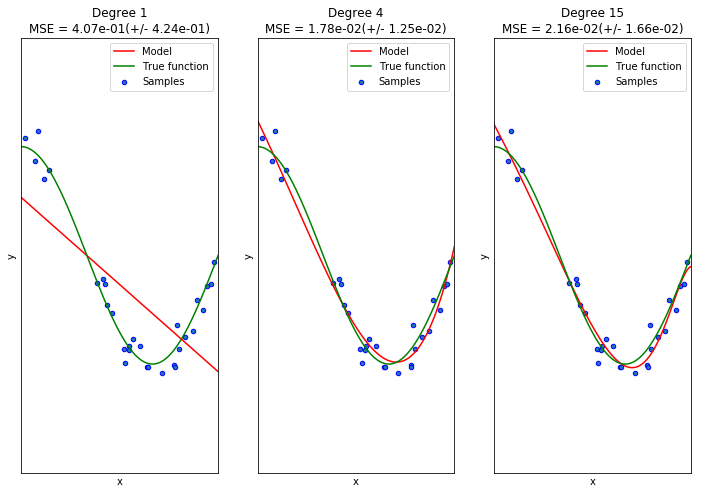

In [15]:
np.random.seed(0)
n_samples = 30

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

degrees = [1, 4, 15]
plt.figure(figsize=(12,8))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    ## CHANGE ALPHA HERE!!
    ridge = Ridge(alpha=0.01)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("ridge", ridge)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model",color='r')
    plt.plot(X_test, true_fun(X_test), label="True function",color='g')
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

### Find optimal alpha for L2 regression by cross validation

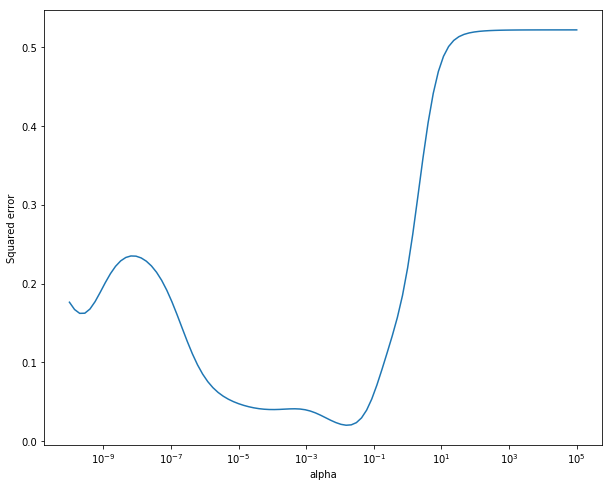

In [16]:
# to find the optimal value of alpha, select the highest degree you want to work with
# and then sweep through the alphas on a logarithmic scale

n_alphas = 100
alphas = np.logspace(-10, 5, n_alphas)
scores = []

for alpha in alphas:
    polynomial_features = PolynomialFeatures(degree=15,
                                             include_bias=False)
    ridge = Ridge(alpha=alpha)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("ridge", ridge)])
    pipeline.fit(X[:, np.newaxis], y)
    score = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)
    scores.append(-np.mean(score))
    
plt.semilogx(alphas,scores)
plt.xlabel('alpha')
plt.ylabel('Squared error')
plt.show()

### Build final L2 regression model with best alpha

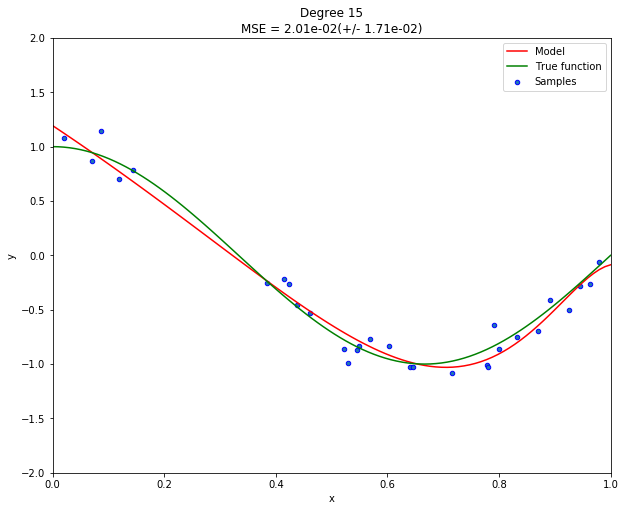

In [17]:
# build the final model with the optimal alpha
best_alpha = alphas[scores.index(min(scores))]

polynomial_features = PolynomialFeatures(degree=15,
                                             include_bias=False)
ridge = Ridge(alpha=best_alpha)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", ridge)])
pipeline.fit(X[:, np.newaxis], y)
score = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

# plot the fit on a new test set
X_test = np.linspace(0, 1, 100)
plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model",color='r')
plt.plot(X_test, true_fun(X_test), label="True function",color='g')
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.legend(loc="best")
plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        15, -score.mean(), score.std()))
plt.show()

### Testing overfitting and underfitting

While
visualizing the best fit as shown is one possible way to debug your learning
algorithm, it is not always easy to visualize the data and model, particularly if the data is high-dimensional. In the next
cell, we show you how to generate learning curves that can
help you debug your learning algorithm even if it is not easy to visualize the
data.

The learning curve is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the cross-validation error and the training error converge to a value that is quite high even with increasing size of the training set, we will need  much more training data.

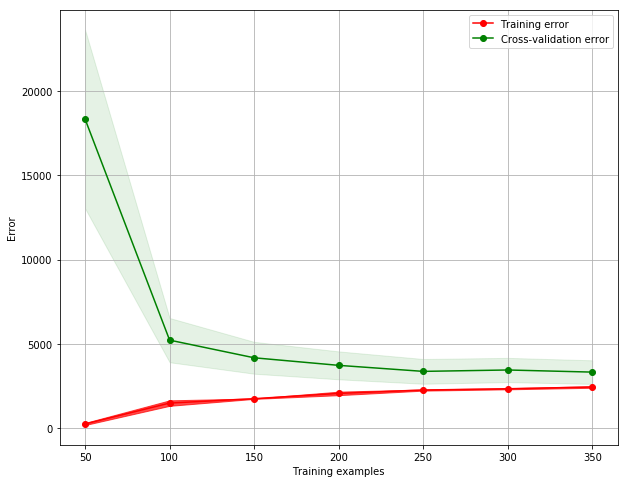

In [18]:
# The diabetes data set 
# The full diabetes data set has 442 examples with 10 features and a real valued target.

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
features = diabetes.feature_names

polynomial_features = PolynomialFeatures(degree=2, include_bias=True)
ridge = Ridge(alpha=0.01,normalize=True)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("ridge", ridge)])

tsizes = range(50,400,50)
train_sizes, train_scores, test_scores = learning_curve(pipeline,X , y, train_sizes=tsizes, 
                                                        scoring='neg_mean_squared_error',cv=10)
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)

plt.xlabel("Training examples")
plt.ylabel("Error")
plt.grid(b=True)
                    
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.7,color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")
plt.legend(loc="best")
    

## L1 regularized regression: a simple example
The true model is  cos(1.5πx) , and the data consists of x drawn from the interval [0,1] and y is the true function with some random Gaussian noise added. The extent of regularization is determined by the parameter alpha.

### Experiment with regularization strength
First set alpha = 0.0, and observe the fits. Then change alpha to 0.01, 0.1, 1.0, 10.0 and 100.0. What do you observe?


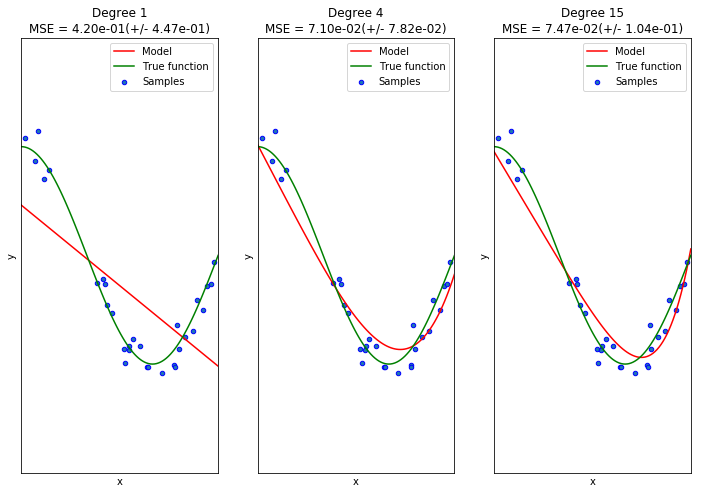

In [19]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(12,8))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    ## CHANGE ALPHA HERE!!
    lasso = Lasso(alpha=0.01)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("lasso", lasso)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model",color='r')
    plt.plot(X_test, true_fun(X_test), label="True function",color='g')
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

### Find optimal value of alpha for L1 regularized model by cross validation

Text(0,0.5,'Squared error')

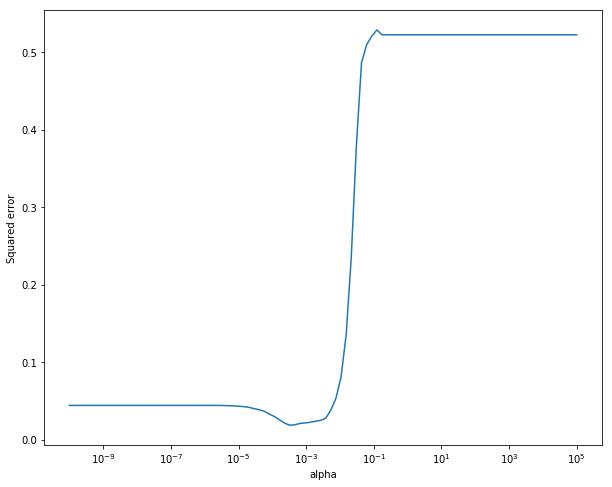

In [20]:
# to find the optimal value of alpha, select the highest degree you want to work with
# and then sweep through the alphas on a logarithmic scale

n_alphas = 100
alphas = np.logspace(-10, 5, n_alphas)
scores = []

for alpha in alphas:
    polynomial_features = PolynomialFeatures(degree=15,
                                             include_bias=False)
    lasso = Lasso(alpha=alpha)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("lasso", lasso)])
    pipeline.fit(X[:, np.newaxis], y)
    score = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)
    scores.append(-np.mean(score))
    
plt.semilogx(alphas,scores)
plt.xlabel('alpha')
plt.ylabel('Squared error')


## Build final L1 model with best alpha

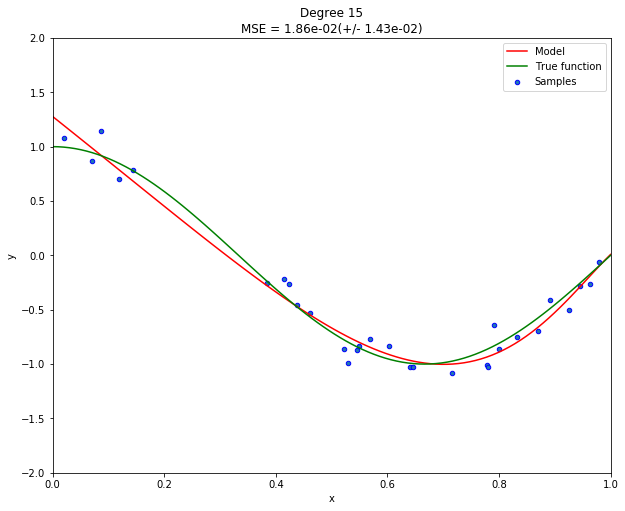

In [21]:
# build the final model with the optimal alpha
best_alpha = alphas[scores.index(min(scores))]

polynomial_features = PolynomialFeatures(degree=15,
                                             include_bias=False)
lasso = Lasso(alpha=best_alpha)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("lasso", lasso)])
pipeline.fit(X[:, np.newaxis], y)
score = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

# plot the fit on a new test set
X_test = np.linspace(0, 1, 100)
plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model",color='r')
plt.plot(X_test, true_fun(X_test), label="True function",color='g')
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.legend(loc="best")
plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        15, -score.mean(), score.std()))
plt.show()

##  Running Lasso on the Diabetes data set

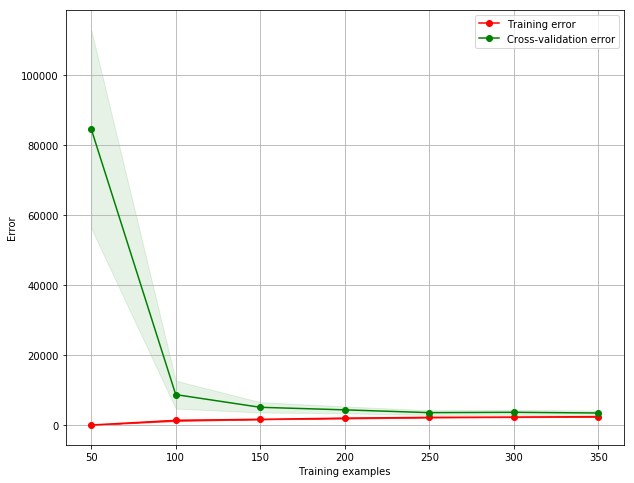

In [22]:
# The diabetes data set 
# The full diabetes data set has 442 examples with 10 features and a real valued target.

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
features = diabetes.feature_names

polynomial_features = PolynomialFeatures(degree=2, include_bias=True)
lasso = Lasso(alpha=0.001,normalize=True)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("lasso", lasso)])

tsizes = range(50,400,50)
train_sizes, train_scores, test_scores = learning_curve(pipeline,X , y, train_sizes=tsizes, 
                                                        scoring='neg_mean_squared_error',cv=10)
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)

plt.xlabel("Training examples")
plt.ylabel("Error")
plt.grid(b=True)
                    
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.7,color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")
plt.legend(loc="best")
    

## Find best configuration for L1 model for diabetes data set
- load the diabetes data set
- set up a pipeline of Polynomial features (degree 2) and Lasso
- explore alphas for Lasso from 10^{-10} to 1 in logspace with 50 uniformly interpolated points (use np.logspace)
- use 10-fold cross validation to find the best alpha (use GridSearchCV)
- plot the results on a semi-log scale, alphas in the log scale on x and cv mean and std error on the y-axis

{'mean_fit_time': array([0.0161509 , 0.01505318, 0.01454663, 0.0143827 , 0.01581395,
        0.01474497, 0.01495051, 0.01435616, 0.01422472, 0.01426935,
        0.0143275 , 0.01428204, 0.01430073, 0.01430535, 0.014362  ,
        0.01559067, 0.01467383, 0.01431539, 0.01860929, 0.01438425,
        0.01413186, 0.01503124, 0.01887152, 0.0189029 , 0.02034802,
        0.01512837, 0.01509724, 0.01611595, 0.02126505, 0.01486719,
        0.01452942, 0.01821742, 0.01496935, 0.01492648, 0.01518703,
        0.01613398, 0.01496518, 0.01258183, 0.00750129, 0.00456138,
        0.00357683, 0.00270653, 0.0021549 , 0.00179601, 0.00183198,
        0.00154841, 0.00147655, 0.00154893, 0.00150108, 0.00166643]),
 'std_fit_time': array([3.02027600e-03, 1.18065789e-03, 3.78657225e-04, 2.62166162e-04,
        8.88604456e-04, 6.47703689e-04, 1.52096422e-03, 2.45074479e-04,
        1.89741133e-04, 1.29626627e-04, 2.03349901e-04, 3.39324485e-04,
        2.18116080e-04, 2.71895562e-04, 2.55909116e-04, 6.39010435e-0

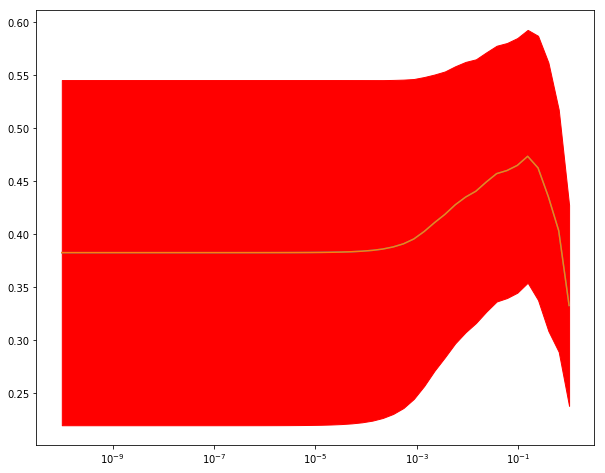

In [24]:
# your code here
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
features = diabetes.feature_names

polynomial_features = PolynomialFeatures(degree=2, include_bias=True)
lasso = Lasso(alpha=0.001,normalize=True)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("lasso", lasso)])


n_alphas = 50
alphas = np.logspace(-10, 0, n_alphas)
clf = GridSearchCV(pipeline, param_grid={'lasso__alpha':alphas}, cv=10)

clf.fit(X, y)
plt.semilogx(alphas, clf.cv_results_['mean_test_score'])

plt.fill_between(alphas, clf.cv_results_['mean_test_score'] + clf.cv_results_['std_test_score'], 
             clf.cv_results_['mean_test_score'] - clf.cv_results_['std_test_score'], color='red')
plt.semilogx(alphas, clf.cv_results_['mean_test_score'])

clf.cv_results_
    


## Fit best L1 model and see coefficients

In [25]:
# your code here
clf.best_estimator_.named_steps['lasso'].coef_


array([ 0.00000000e+00,  0.00000000e+00, -2.10345185e-01,  5.01899198e+02,
        2.48117106e+02, -0.00000000e+00, -0.00000000e+00, -1.83256006e+02,
        0.00000000e+00,  4.66914589e+02,  1.55050031e+01,  7.36231954e+01,
        2.22616130e+03,  0.00000000e+00,  6.65568404e+02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.54021809e+02,
        2.83955070e+02, -1.74213820e+04,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.40123383e+02,  1.65402354e+03,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

## Find best configuration for L2 model for diabetes data set 
- follow the same protocol as for L1

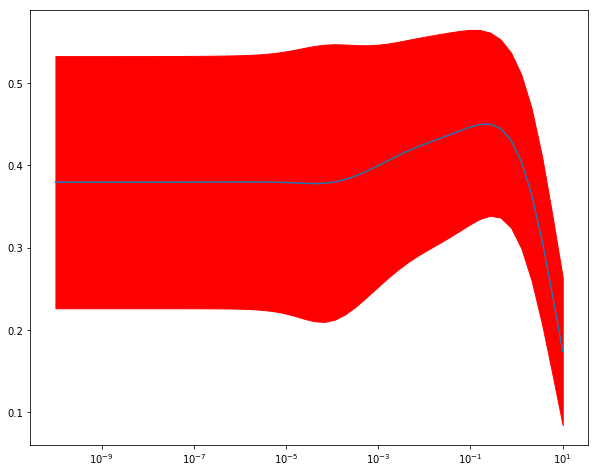

In [27]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
features = diabetes.feature_names

polynomial_features = PolynomialFeatures(degree=2, include_bias=True)
ridge = Ridge(normalize=True)
pipeline = Pipeline([("polynomial_features", polynomial_features), ("ridge", ridge)])

alphas = np.logspace(-10, 1, 50)
clf2 = GridSearchCV(pipeline, param_grid={'ridge__alpha':alphas}, cv=10)
clf2.fit(X, y)

plt.fill_between(alphas, clf2.cv_results_['mean_test_score'] + clf2.cv_results_['std_test_score'], 
             clf2.cv_results_['mean_test_score'] - clf2.cv_results_['std_test_score'], color='red')
plt.semilogx(alphas, clf2.cv_results_['mean_test_score'])

## Fit best L2 model and see coefficients

In [ ]:
clf2.best_estimator_.named_steps['ridge'].coef_


## Which is the better model for the diabetes data set: L1 or L2 regularized?

In [28]:
# Your explanation here
print(clf.best_score_)
print(clf2.best_score_)

#Lasso works better according to these values.

0.4500446324844474
0.4500446324844474


## k-Nearest Neighbors
Use sklearn's k-nearest neighbor function to learn a model on the diabetes data set in a cross-validated setting. Tune the best value of k for your model using GridSearchCV.

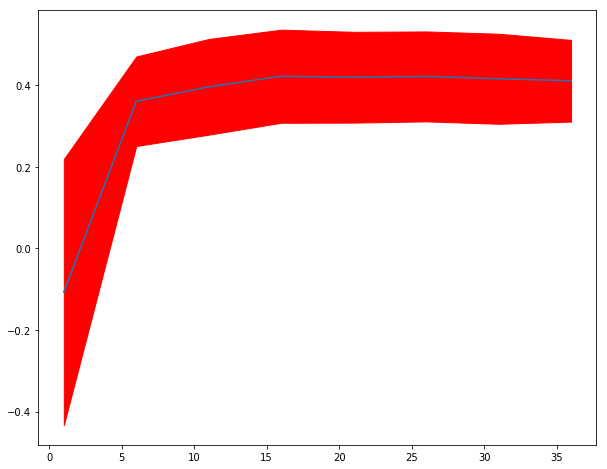

In [29]:
# your code here
from sklearn.neighbors import KNeighborsRegressor

nb = KNeighborsRegressor()
neighbors = np.arange(1,40,5)
kNear = GridSearchCV(nb, param_grid={'n_neighbors':neighbors}, cv=10)
kNear.fit(X, y)

plt.fill_between(neighbors, kNear.cv_results_['mean_test_score'] + kNear.cv_results_['std_test_score'], 
             kNear.cv_results_['mean_test_score'] - kNear.cv_results_['std_test_score'], color='red')
plt.plot(neighbors, kNear.cv_results_['mean_test_score'])

## Decision Tree Regressor
Use sklearn's decision tree regressor for the diabetes data set in a crossvalidated setting. Tune the max-depth parameter for your model using GridSearchCV.

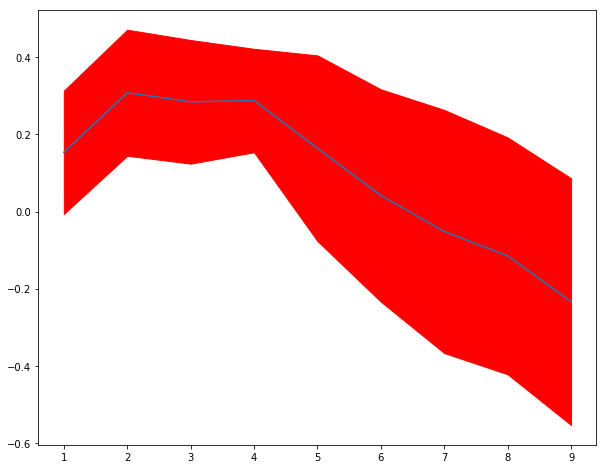

In [30]:
# your code here
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
depth = np.arange(1,10)
dTree = GridSearchCV(tree, param_grid={'max_depth':depth}, cv=10)
dTree.fit(X, y)

plt.fill_between(depth, dTree.cv_results_['mean_test_score'] + dTree.cv_results_['std_test_score'], 
             dTree.cv_results_['mean_test_score'] - dTree.cv_results_['std_test_score'], color='red')
plt.plot(depth, dTree.cv_results_['mean_test_score'])

## RandomForest Regressor
Use sklearn's random forest regressor for the diabetes data set in a crossvalidated setting. Tune the n_estimators and max-depth parameter for your model using GridSearchCV.

{'max_depth': 3, 'n_estimators': 8}

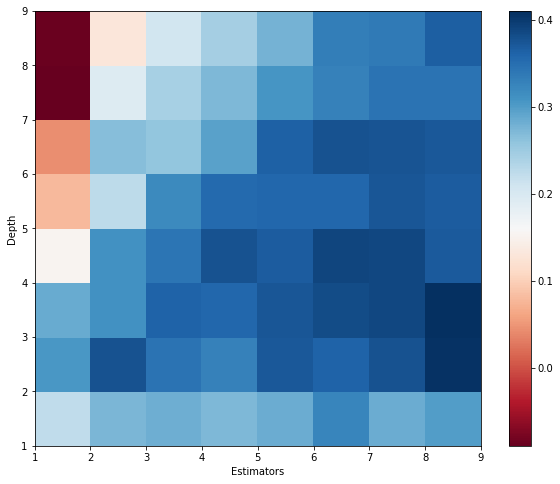

In [32]:
# your code here
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
n_estimators = np.arange(1,10)
depth = np.arange(1,10)
rForest = GridSearchCV(forest, param_grid={'max_depth':depth, 'n_estimators': n_estimators}, cv=10)
rForest.fit(X, y)

matrix = np.zeros((9,9))
for i, j in zip(rForest.cv_results_['params'], rForest.cv_results_['mean_test_score']):
    matrix[i['max_depth'] - 1, i['n_estimators'] - 1] = j
matrix

plt.pcolor(n_estimators, depth, matrix, cmap='RdBu')
plt.colorbar()
plt.xlabel('Estimators')
plt.ylabel('Depth')

rForest.best_params_